In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.optim as optim
from torchvision import transforms, models, utils
from PIL import Image, ImageOps
import numpy as np

# 逆伝搬の際に影響を受けないように
vgg = models.vgg19(pretrained=True).features
for param in vgg.parameters():
    param.requires_grad_(False)
    
# GPUが使えるときは使用し、不可の際はCPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

In [13]:
def load_image(img_path, max_size=400, shape=None, invert=False):
    """
    note : image画像の編集
    ----------
    max_size : max_size of image
    shape : shape of the tensor
    ----------
    """
    image = Image.open(img_path).convert('L')
    if invert == True:
        image = ImageOps.invert(image)
    image = image.convert("RGB")

    if shape is not None:
        size = shape

    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)

    in_transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5),
                            (0.5, 0.5, 0.5))
    ])

    image = in_transform(image).unsqueeze(0)

    return image

content = load_image('data/takaya2.PNG', invert=True).to(device)
style = load_image('data/takaya_style.jpg', shape=content.shape[-2:]).to(device) # shapeがcontentと揃うように読み込み

(-0.5, 399.5, 399.5, -0.5)

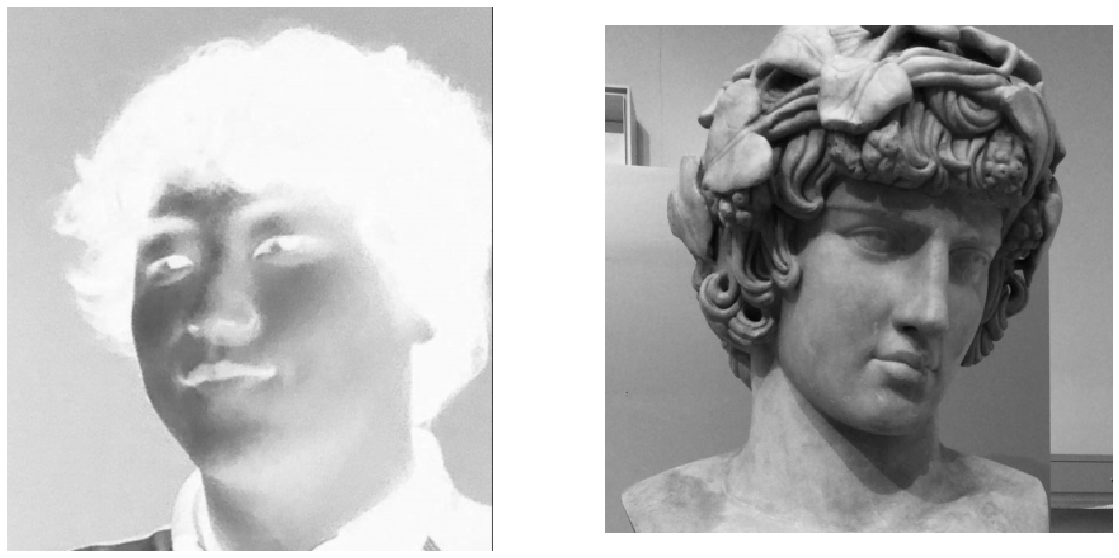

In [14]:
def im_convert(tensor):
    """
    note : tensor to numpy
    ----------
    tensor : tensor
    ----------
    """
    image = tensor.clone().detach().cpu().numpy()
    # squeeze : Returns a tensor with all the dimensions of input of size 1 removed.
    image = image.squeeze()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)
    return image


# 用いる画像の可視化（確認）
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax1.axis('off')
ax2.imshow(im_convert(style))
ax2.axis('off')

In [15]:
def get_features(image, model):
    """
    note : CNNの特定層から特徴量を抽出する関数
    ----------
    image : tensor
    model : type of CNN(今回はVGG19)
    ----------
    """
    layers = {
        "0" : "conv1_1",
        "5" : "conv2_1",
        "10" : "conv3_1",
        "19" : "conv4_1",
        "21" : "conv4_2",
        "28" : "conv5_1",
    }

    features = {}

    #odict_items([('0', Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('1', ReLU...
    for name, layer in model._modules.items():
        image = layer(image)
        if name in layers:
            # {'conv1_1': tensor([...
            features[layers[name]] = image

    return features

In [16]:
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

In [17]:
def gram_matrix(tensor):
    """
    note : グラム行列の計算(X.T @ X)
    ----------
    tensor : tensor
    ----------
    """
    # arbitrary vector times vector.T
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h*w)
    gram = torch.mm(tensor, tensor.t())
    return gram


style_grams = {layer : gram_matrix(style_features[layer]) for layer in style_features}

In [18]:
style_weights = {
    "conv1_1" : 1.,
    "conv2_1" : 0.75,
    "conv3_1" : 0.2,
    "conv4_1" : 0.2,
    "conv5_1" : 0.2
}
content_weight = 0.1
style_weight = 1e6

In [19]:
# target imgの最適化
target = content.clone().requires_grad_(True).to(device)

In [20]:
# 300iterlationごとに可視化
show_every = 300
optimizer = optim.Adam([target], lr=0.003)
steps = 3000
heights, widths, channels = im_convert(target).shape
image_array = np.empty(shape=(300, heights, widths, channels))
capture_frame = steps / 300
counter = 0

total loss 627972.875
iterlation 300


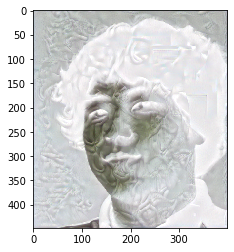

total loss 497463.0625
iterlation 600


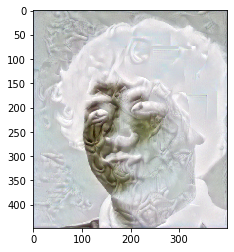

total loss 425024.8125
iterlation 900


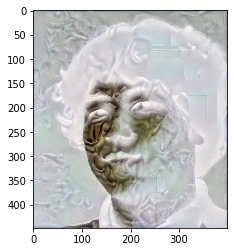

total loss 369279.15625
iterlation 1200


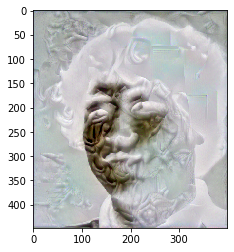

total loss 319155.21875
iterlation 1500


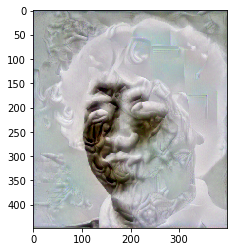

total loss 271705.21875
iterlation 1800


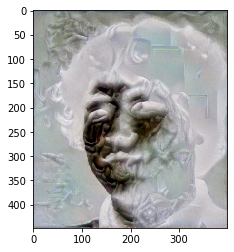

total loss 232426.421875
iterlation 2100


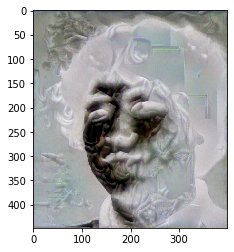

total loss 204225.265625
iterlation 2400


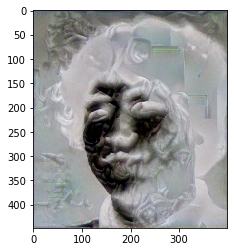

total loss 180359.5
iterlation 2700


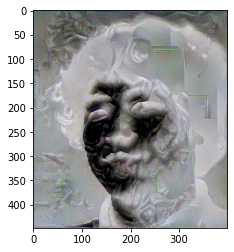

total loss 164974.25
iterlation 3000


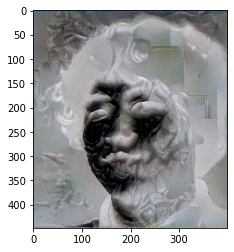

(-0.5, 399.5, 447.5, -0.5)

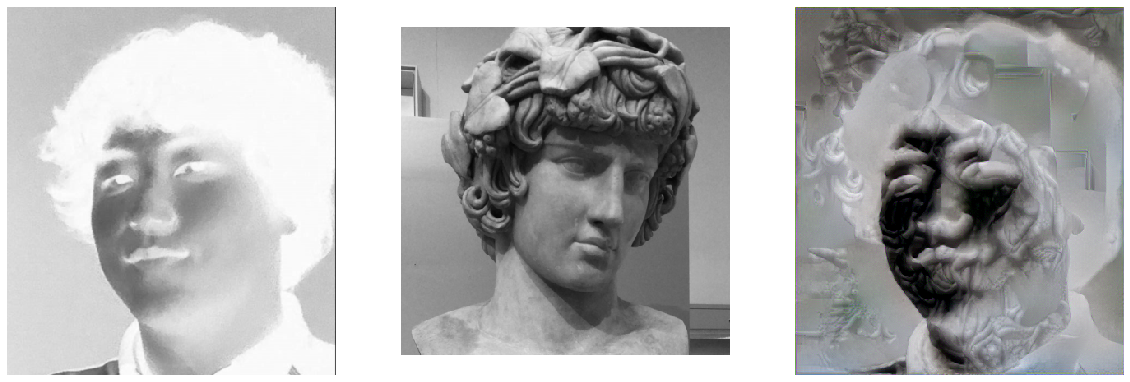

In [21]:
for ii in range(1, steps+1):
    target_features = get_features(target, vgg)
    content_loss = torch.mean((target_features['conv5_1'] - content_features['conv5_1']) **2)
    style_loss = 0

    # layerは辞書のキー
    for layer in style_weights:
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        style_gram = style_grams[layer]
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram) **2)
        _, d, h, w = target_feature.shape
        # unit lossを得るためにnormalizeする必要がある
        style_loss += layer_style_loss / (d * h * w)

    total_loss = content_weight * content_loss + style_weight * style_loss
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if ii % show_every == 0:
        print('total loss' , total_loss.item())
        print('iterlation' , ii)
        plt.imshow(im_convert(target))
        plt.show()
    if ii % capture_frame == 0:
        image_array[counter] = im_convert(target)
        counter = counter + 1


# content, style, targetの全画像の可視化
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.imshow(im_convert(content))
ax1.axis('off')
ax2.imshow(im_convert(style))
ax2.axis('off')
ax3.imshow(im_convert(target))


# target画像の保存
utils.save_image(target, 'target.png', nrow=4)
ax3.axis('off')